<a href="https://colab.research.google.com/github/RifadahHusna/Machine_Learning_Project/blob/main/Project_Machine_Learningg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LOAD DATASET

In [ ]:
!pip install os

Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement os (from versions: none)

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for os


In [ ]:
# =========================================================
# 0. Download ZIP → Ekstrak → Cek isi dataset (pakai dataset_dir)
# =========================================================

# 1. Install gdown
!pip install gdown -q

import gdown, zipfile, os

file_id = "1z2zFGfVzjY282I7Oudw_CXDqvxw3ISul"
output_zip = "dataset.zip"

# Folder hasil ekstrak (level 1)
root_dir = "dataset_dir"

print("Downloading ZIP dataset...")
gdown.download(id=file_id, output=output_zip, quiet=False)
print("Download selesai!")

print("Mengekstrak ZIP...")
os.makedirs(root_dir, exist_ok=True)

with zipfile.ZipFile(output_zip, 'r') as z:
    z.extractall(root_dir)

print("Ekstraksi selesai!")

# =========================================================
# Set dataset_dir ke folder yg berisi kelas (Normal, Tumor)
# =========================================================
dataset_dir = os.path.join(root_dir, "Label")

print("\nIsi dataset_dir:", dataset_dir)
print(os.listdir(dataset_dir))

print("\nJumlah file per kelas:")
for folder in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, folder)
    if os.path.isdir(class_path):
        print(f"- {folder}: {len(os.listdir(class_path))} files")


Downloading...
From (original): https://drive.google.com/uc?id=1z2zFGfVzjY282I7Oudw_CXDqvxw3ISul
From (redirected): https://drive.google.com/uc?id=1z2zFGfVzjY282I7Oudw_CXDqvxw3ISul&confirm=t&uuid=61f044dc-be68-4201-8b5d-20376ad17d16
To: /content/dataset.zip
100%|██████████| 841M/841M [00:03<00:00, 241MB/s]


Download selesai!
Mengekstrak ZIP...
Ekstraksi selesai!

Isi dataset_dir: dataset_dir/Label
['Normal', 'Tumor']

Jumlah file per kelas:
- Normal: 1879 files
- Tumor: 1867 files


Found 3746 files belonging to 2 classes.
Using 2997 files for training.
Found 3746 files belonging to 2 classes.
Using 749 files for validation.
Kelas: ['Normal', 'Tumor']


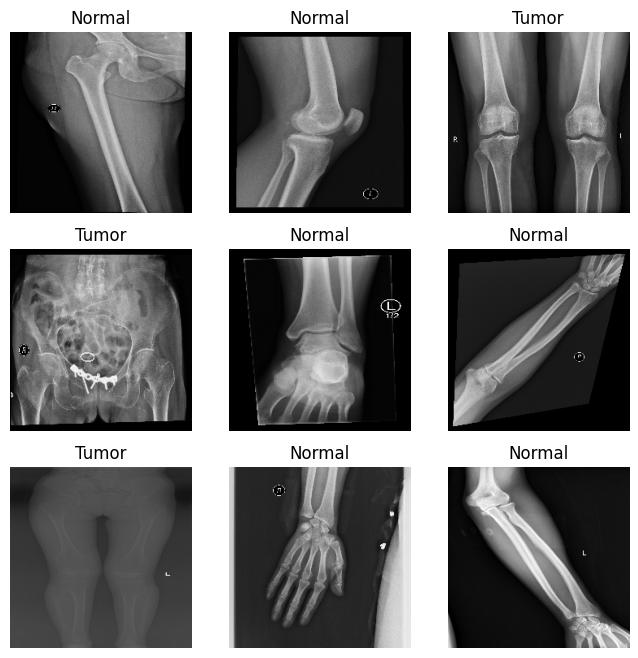

Dataset sudah siap dan dioptimasi.



In [ ]:

# ==============================
# 1. Load Dataset menggunakan Keras
# ==============================
import tensorflow as tf
from tensorflow.keras import layers, Sequential
import matplotlib.pyplot as plt

batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names
print("Kelas:", class_names)

# Visualisasi sampel
plt.figure(figsize=(8,8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

# Optimasi pipeline dataset
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("Dataset sudah siap dan dioptimasi.\n")


# PREPROCESSING

Data training: (2997, 224, 224, 3), Data validation: (749, 224, 224, 3)


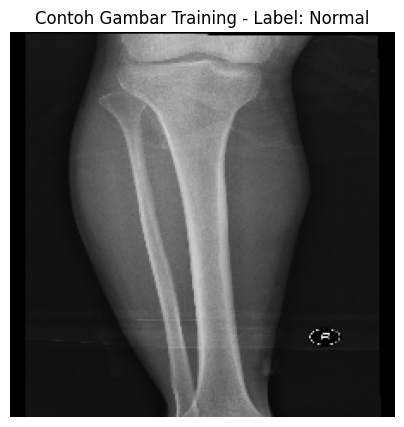

In [ ]:
# ==============================
# 2. Konversi dataset ke numpy untuk ekstraksi fitur klasik
# ==============================
import numpy as np

def dataset_to_numpy(dataset):
    X, y = [], []
    for images, labels in dataset:
        for i in range(images.shape[0]):
            X.append(images[i].numpy().astype("uint8"))
            y.append(labels[i].numpy())
    return np.array(X), np.array(y)

X_train_np, y_train_np = dataset_to_numpy(train_ds)
X_val_np, y_val_np = dataset_to_numpy(val_ds)

print(f"Data training: {X_train_np.shape}, Data validation: {X_val_np.shape}")
plt.figure(figsize=(5,5))
plt.imshow(X_train_np[0])
plt.title(f"Contoh Gambar Training - Label: {class_names[y_train_np[0]]}")
plt.axis("off")
plt.show()

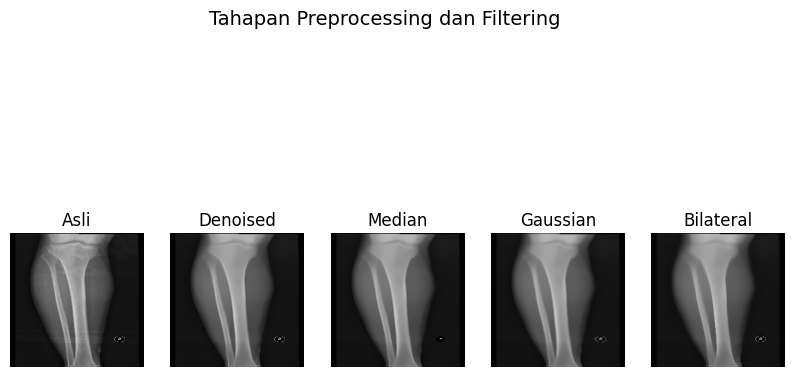

Filtering selesai diterapkan pada seluruh dataset.



In [ ]:
# ==============================
# 3. PREPROCESSING + FILTERING
# ==============================
import cv2

def preprocess_image(img):
    # Resize
    img_resized = cv2.resize(img, (224, 224))
    # Normalisasi
    img_norm = cv2.normalize(img_resized, None, 0, 255, cv2.NORM_MINMAX)
    # Denoising
    img_denoised = cv2.fastNlMeansDenoisingColored(img_norm, None, 10, 10, 7, 21)
    # Filtering
    img_median = cv2.medianBlur(img_denoised, 3)
    img_gaussian = cv2.GaussianBlur(img_denoised, (3,3), 0)
    img_bilateral = cv2.bilateralFilter(img_denoised, 9, 75, 75)
    return img_denoised, img_median, img_gaussian, img_bilateral

# Visualisasi hasil preprocessing & filtering
sample_img = X_train_np[0]
denoised, median, gaussian, bilateral = preprocess_image(sample_img)

plt.figure(figsize=(10,6))
plt.subplot(1,5,1); plt.imshow(sample_img); plt.title("Asli"); plt.axis("off")
plt.subplot(1,5,2); plt.imshow(denoised); plt.title("Denoised"); plt.axis("off")
plt.subplot(1,5,3); plt.imshow(median); plt.title("Median"); plt.axis("off")
plt.subplot(1,5,4); plt.imshow(gaussian); plt.title("Gaussian"); plt.axis("off")
plt.subplot(1,5,5); plt.imshow(bilateral); plt.title("Bilateral"); plt.axis("off")
plt.suptitle("Tahapan Preprocessing dan Filtering", fontsize=14)
plt.show()

# Terapkan filtering (gunakan hasil bilateral karena paling halus)
X_train_filtered = np.array([preprocess_image(img)[-1] for img in X_train_np])
X_val_filtered = np.array([preprocess_image(img)[-1] for img in X_val_np])
print("Filtering selesai diterapkan pada seluruh dataset.\n")


# FEATURE EXCTRACTION

In [ ]:
# ==============================
# 3. Ekstraksi fitur untuk seluruh dataset + visualisasi
# ==============================
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops, hog
from tqdm import tqdm

# Untuk reproducibility
np.random.seed(42)

def extract_features(image):
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # HOG (gunakan skimage agar bisa divisualisasikan)
    hog_feat, hog_img = hog(gray, visualize=True, block_norm='L2-Hys')
    h = hog_feat.flatten()

    # LBP manual
    lbp = np.zeros_like(gray)
    for i in range(1, gray.shape[0]-1):
        for j in range(1, gray.shape[1]-1):
            center = gray[i,j]
            binary = (gray[i-1:i+2, j-1:j+2]>=center).astype(int)
            binary = np.delete(binary.flatten(),4)
            lbp[i,j] = binary.dot(1 << np.arange(binary.size)[::-1])
    lbp_hist,_ = np.histogram(lbp.ravel(), bins=64, range=(0,256))
    lbp_hist = lbp_hist / np.sum(lbp_hist)

    # Histogram Warna
    hist_feat = []
    for i in range(3):
        hist = cv2.calcHist([image],[i],None,[64],[0,256])
        hist_feat.extend(hist.flatten())
    hist_feat = np.array(hist_feat) / np.sum(hist_feat)

    # GLCM
    glcm = graycomatrix(gray, distances=[1],
                        angles=[0,np.pi/4,np.pi/2,3*np.pi/4],
                        symmetric=True, normed=True)
    glcm_feat = np.array([
        graycoprops(glcm,'contrast').mean(),
        graycoprops(glcm,'dissimilarity').mean(),
        graycoprops(glcm,'homogeneity').mean(),
        graycoprops(glcm,'energy').mean(),
        graycoprops(glcm,'correlation').mean(),
        graycoprops(glcm,'ASM').mean()
    ])

    # Hu Moments
    moments = cv2.moments(gray)
    hu = cv2.HuMoments(moments).flatten()
    hu_feat = -np.sign(hu)*np.log10(np.abs(hu)+1e-10)

    # Edge Histogram
    edges = cv2.Canny(gray,100,200)
    edge_hist,_ = np.histogram(edges.ravel(),bins=32,range=(0,256))
    edge_feat = edge_hist / np.sum(edge_hist)

    # Gabor Filter
    gabor_feat = []
    for theta in (0,np.pi/4,np.pi/2,3*np.pi/4):
        for sigma in (1,3):
            kernel = cv2.getGaborKernel((9,9), sigma, theta, 8.0,0.5,0, ktype=cv2.CV_32F)
            fimg = cv2.filter2D(gray, cv2.CV_8UC3, kernel)
            gabor_feat.extend([np.mean(fimg), np.std(fimg)])
    gabor_feat = np.array(gabor_feat)

    return {
        "HOG": h,
        "HOG Image": hog_img,
        "LBP": lbp_hist,
        "LBP Image": lbp,
        "Histogram Warna": hist_feat,
        "GLCM": glcm_feat,
        "Hu Moments": hu_feat,
        "Edge Histogram": edge_feat,
        "Edge Image": edges,
        "Gabor Filter": gabor_feat
    }

Ekstraksi fitur:   0%|          | 0/2997 [00:00<?, ?it/s]

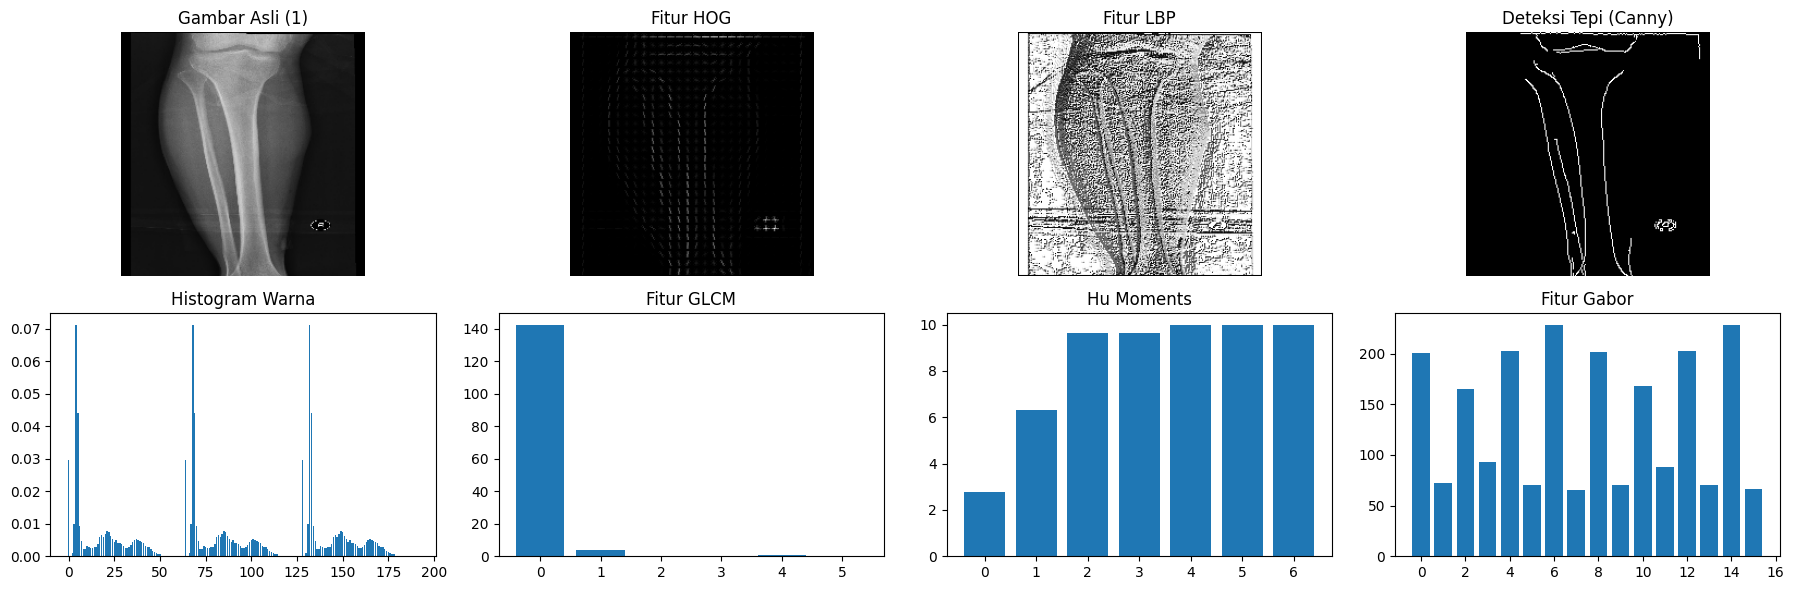

Ekstraksi fitur:   0%|          | 1/2997 [00:02<1:59:57,  2.40s/it]


Fitur numerik contoh gambar 1:
HOG: [0. 0. 0. 0. 0.] ...
LBP: [0.05913186 0.01070233 0.01375159 0.00500239 0.00864955] ...
Histogram Warna: [2.9536033e-02 5.3146257e-05 9.6327596e-04 1.0018069e-02 7.1348853e-02] ...
GLCM: [1.42589812e+02 4.07376622e+00 4.77653886e-01 1.23869871e-01
 9.76911262e-01] ...
Hu Moments: [ 2.75757863  6.30082637  9.64715729  9.63953139 10.        ] ...
Edge Histogram: [0.97512755 0.         0.         0.         0.        ] ...
Gabor Filter: [200.73120615  71.93819091 164.75354751  93.17941868 202.68877551] ...


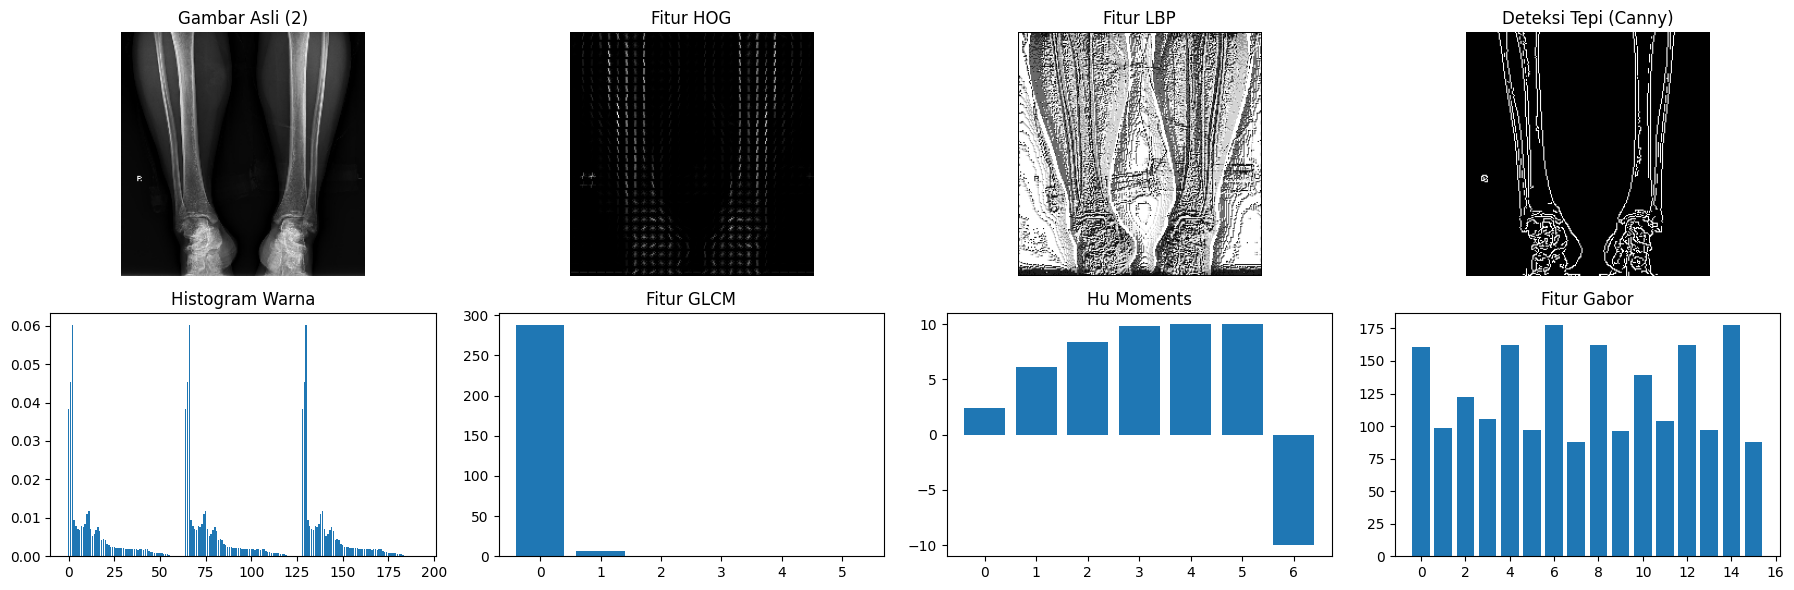

Ekstraksi fitur:   0%|          | 2/2997 [00:05<2:22:33,  2.86s/it]


Fitur numerik contoh gambar 2:
HOG: [0.0552812  0.         0.00244311 0.00386289 0.01739815] ...
LBP: [0.05921158 0.00831075 0.01056282 0.0064772  0.00504225] ...
Histogram Warna: [0.03839153 0.04522746 0.06029443 0.00951318 0.00779921] ...
GLCM: [2.88386585e+02 6.68581554e+00 4.60831627e-01 9.76715777e-02
 9.44157092e-01] ...
Hu Moments: [ 2.43076185  6.12449479  8.36706497  9.8538427  10.        ] ...
Edge Histogram: [0.92849171 0.         0.         0.         0.        ] ...
Gabor Filter: [160.76524633  98.20820901 122.30058195 105.31556502 162.40642937] ...


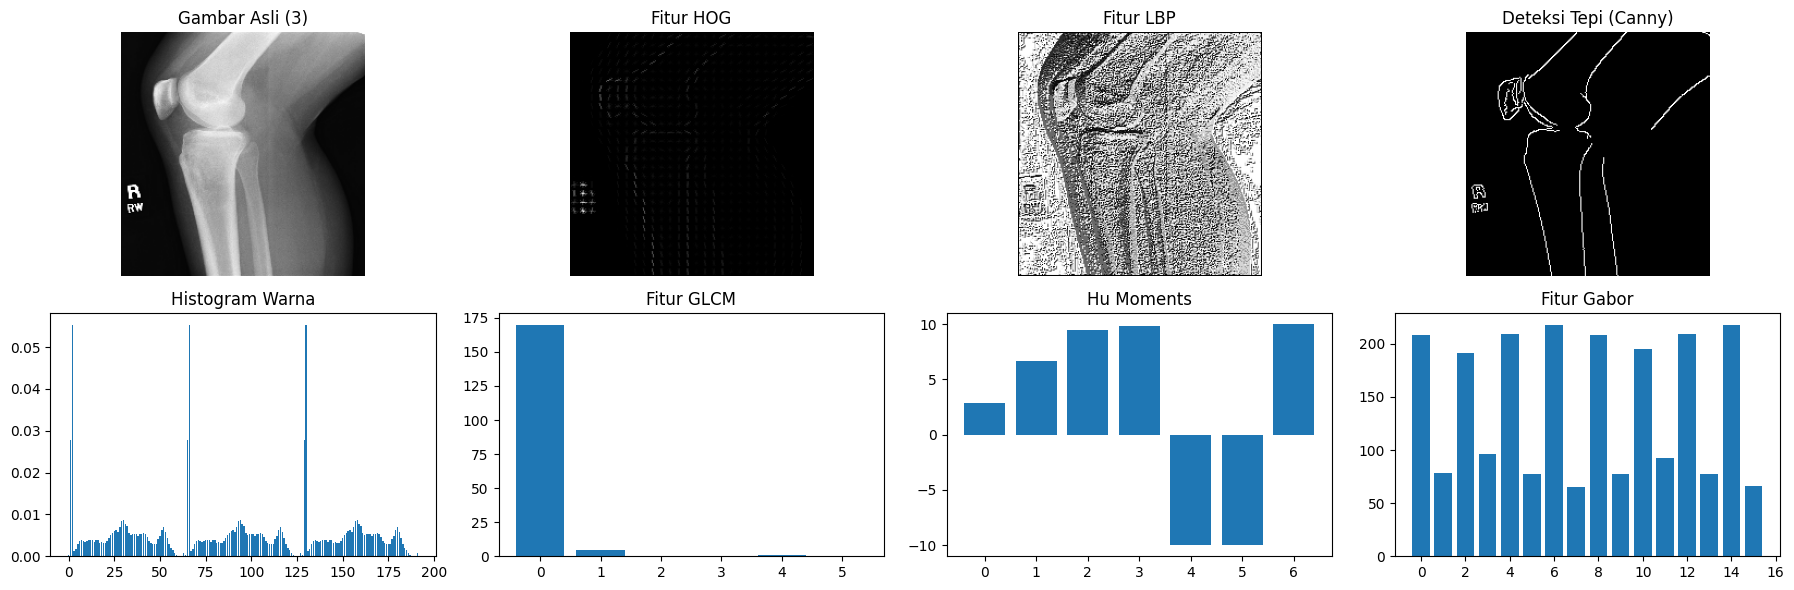

Ekstraksi fitur:   0%|          | 3/2997 [00:07<1:55:51,  2.32s/it]


Fitur numerik contoh gambar 3:
HOG: [0.24100475 0.         0.17234375 0.         0.10445609] ...
LBP: [0.06901706 0.01367188 0.016761   0.00743383 0.01155931] ...
Histogram Warna: [0.00026573 0.02785528 0.05540498 0.00132201 0.00166746] ...
GLCM: [1.70075682e+02 4.36807894e+00 3.59437507e-01 8.11960884e-02
 9.83419330e-01] ...
Hu Moments: [  2.87856105   6.66550474   9.48864499   9.85433789 -10.        ] ...
Edge Histogram: [0.97608418 0.         0.         0.         0.        ] ...
Gabor Filter: [208.36886161  78.45612749 191.36306202  96.15083858 209.08695392] ...


Ekstraksi fitur:   0%|          | 0/749 [00:00<?, ?it/s]

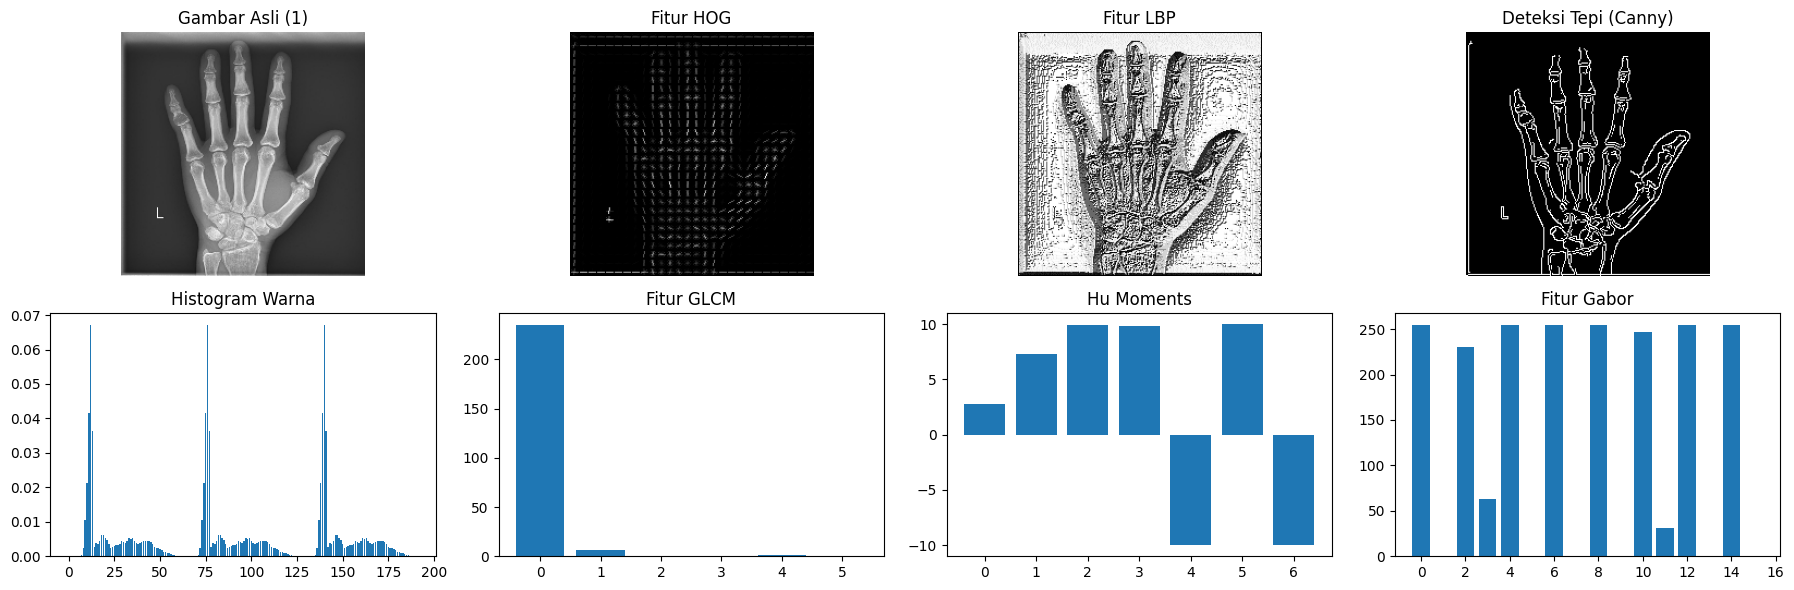

Ekstraksi fitur:   0%|          | 1/749 [00:01<22:34,  1.81s/it]


Fitur numerik contoh gambar 1:
HOG: [0.05176818 0.02473159 0.01085926 0.0249401  0.05877289] ...
LBP: [0.04544005 0.01054289 0.01367188 0.00986527 0.00482302] ...
Histogram Warna: [0. 0. 0. 0. 0.] ...
GLCM: [2.35342653e+02 6.71589778e+00 4.47992232e-01 9.08329756e-02
 9.55701363e-01] ...
Hu Moments: [  2.78014673   7.24632695   9.93701206   9.78057575 -10.        ] ...
Edge Histogram: [0.91838728 0.         0.         0.         0.        ] ...
Gabor Filter: [255.           0.         230.55175781  63.14149006 255.        ] ...


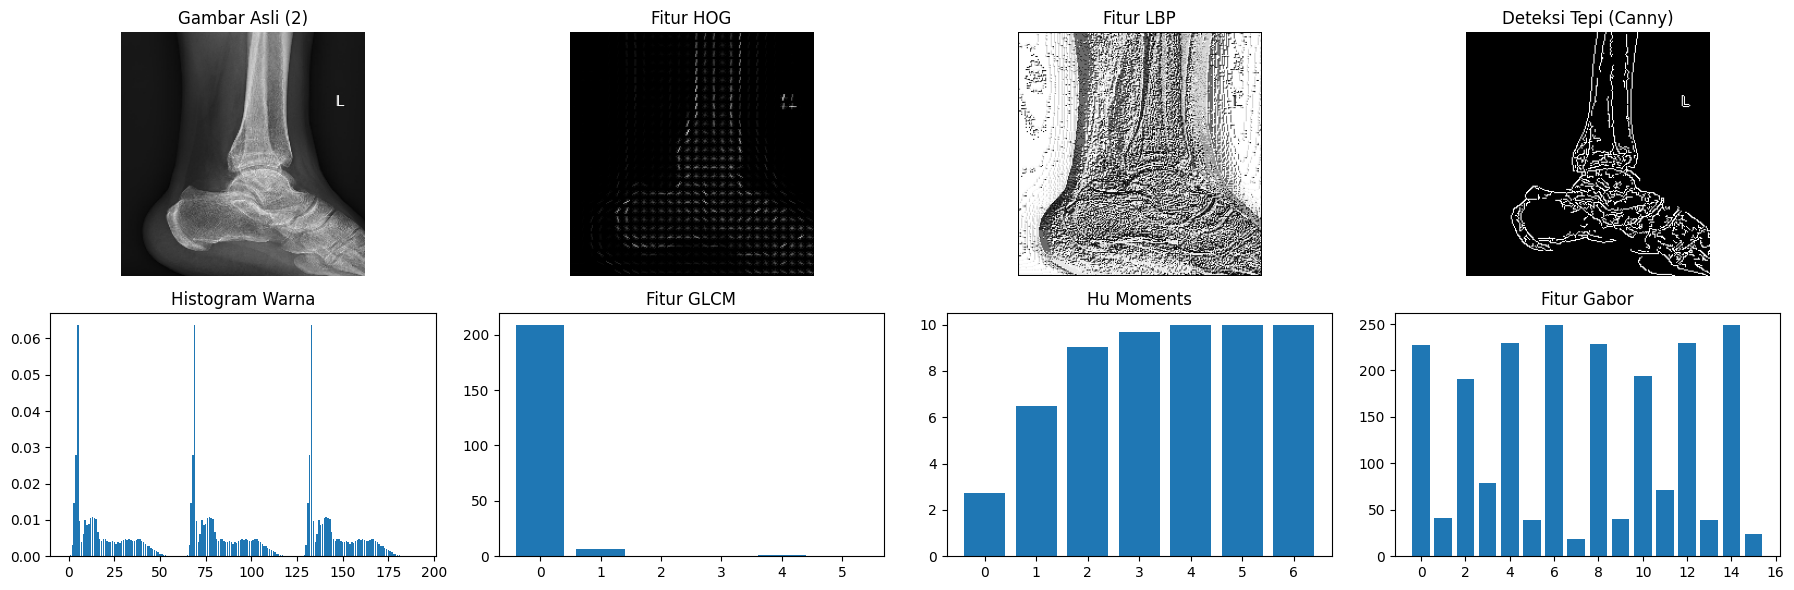

Ekstraksi fitur:   0%|          | 2/749 [00:03<21:40,  1.74s/it]


Fitur numerik contoh gambar 2:
HOG: [0. 0. 0. 0. 0.] ...
LBP: [0.06760204 0.01235651 0.01574458 0.00589923 0.01020408] ...
Histogram Warna: [6.64328218e-06 2.52444734e-04 3.08912620e-03 1.45886475e-02
 2.77954936e-02] ...
GLCM: [2.09122074e+02 6.63755151e+00 4.33267192e-01 8.98999952e-02
 9.63708956e-01] ...
Hu Moments: [ 2.7174612   6.49893877  9.01919286  9.6689236  10.        ] ...
Edge Histogram: [0.93164062 0.         0.         0.         0.        ] ...
Gabor Filter: [227.67384805  40.8618804  190.4923868   78.52936312 229.32242506] ...


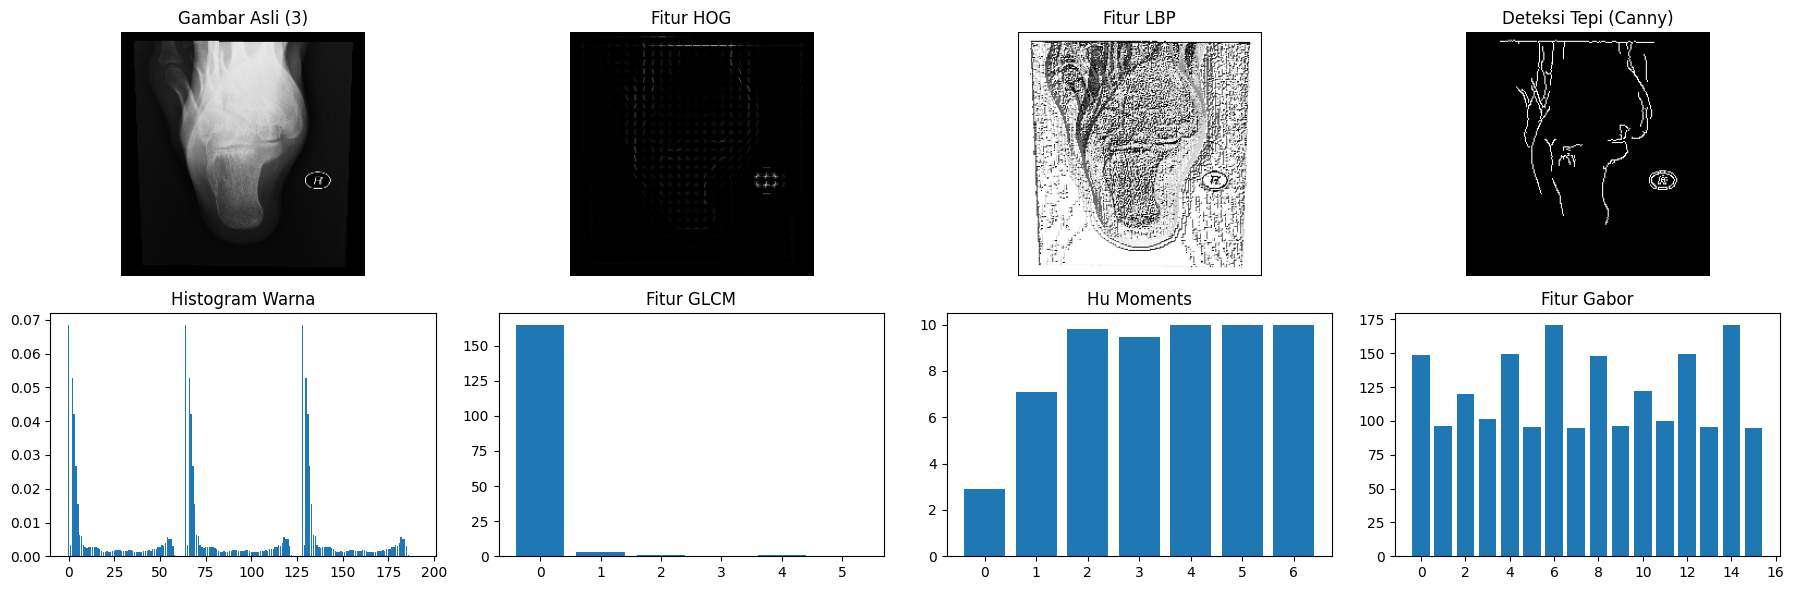

Ekstraksi fitur:   0%|          | 3/749 [00:05<21:29,  1.73s/it]


Fitur numerik contoh gambar 3:
HOG: [0. 0. 0. 0. 0.] ...
LBP: [0.04424426 0.00530134 0.00944675 0.00283004 0.00532127] ...
Histogram Warna: [0.06860518 0.00345451 0.05274102 0.04221142 0.026706  ] ...
GLCM: [165.01754563   3.31217148   0.60516282   0.20902843   0.98455273] ...
Hu Moments: [ 2.90595627  7.10559672  9.80007844  9.46785783 10.        ] ...
Edge Histogram: [0.97470902 0.         0.         0.         0.        ] ...
Gabor Filter: [148.38636001  96.14710928 120.23180405 101.65515386 149.64738122] ...


Ekstraksi fitur: 100%|██████████| 749/749 [10:18<00:00,  1.21it/s]


✅ Ekstraksi fitur selesai.



In [ ]:
def extract_features_batch(X):
    # dictionary penampung
    all_feats = {k: [] for k in ["HOG","LBP","Histogram Warna","GLCM","Hu Moments","Edge Histogram","Gabor Filter"]}

    for idx, img in enumerate(tqdm(X, desc="Ekstraksi fitur")):
        feats = extract_features(img)

        # --- Visualisasi untuk 3 gambar pertama ---
        if idx < 3:
            plt.figure(figsize=(18,6))

            # Gambar asli
            plt.subplot(2,4,1)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title(f"Gambar Asli ({idx+1})")
            plt.axis('off')

            # HOG
            plt.subplot(2,4,2)
            plt.imshow(feats["HOG Image"], cmap='gray')
            plt.title("Fitur HOG")
            plt.axis('off')

            # LBP
            plt.subplot(2,4,3)
            plt.imshow(feats["LBP Image"], cmap='gray')
            plt.title("Fitur LBP")
            plt.axis('off')

            # Edge
            plt.subplot(2,4,4)
            plt.imshow(feats["Edge Image"], cmap='gray')
            plt.title("Deteksi Tepi (Canny)")
            plt.axis('off')

            # Histogram Warna
            plt.subplot(2,4,5)
            plt.bar(range(len(feats["Histogram Warna"])), feats["Histogram Warna"])
            plt.title("Histogram Warna")

            # GLCM
            plt.subplot(2,4,6)
            plt.bar(range(len(feats["GLCM"])), feats["GLCM"])
            plt.title("Fitur GLCM")

            # Hu Moments
            plt.subplot(2,4,7)
            plt.bar(range(len(feats["Hu Moments"])), feats["Hu Moments"])
            plt.title("Hu Moments")

            # Gabor Filter
            plt.subplot(2,4,8)
            plt.bar(range(len(feats["Gabor Filter"])), feats["Gabor Filter"])
            plt.title("Fitur Gabor")

            plt.tight_layout()
            plt.show()

            print(f"\nFitur numerik contoh gambar {idx+1}:")
            for k,v in feats.items():
                if isinstance(v, np.ndarray) and v.ndim == 1:
                    print(f"{k}: {v[:5]} ...")  # tampilkan 5 elemen pertama

        # Simpan fitur numerik
        for k in all_feats.keys():
            all_feats[k].append(feats[k])

    # ubah ke numpy array
    for k in all_feats.keys():
        all_feats[k] = np.array(all_feats[k])
    return all_feats

X_train_feats = extract_features_batch(X_train_np)
X_val_feats   = extract_features_batch(X_val_np)

print("\n✅ Ekstraksi fitur selesai.\n")

In [ ]:
# ==============================
# 5. Normalisasi fitur
# ==============================
from sklearn.preprocessing import StandardScaler
scalers = {}
for k in X_train_feats.keys():
    scaler = StandardScaler()
    X_train_feats[k] = scaler.fit_transform(X_train_feats[k])
    X_val_feats[k]   = scaler.transform(X_val_feats[k])
    scalers[k] = scaler
    print(f"Fitur {k} dinormalisasi. Shape: {X_train_feats[k].shape}")

Fitur HOG dinormalisasi. Shape: (2997, 54756)
Fitur LBP dinormalisasi. Shape: (2997, 64)
Fitur Histogram Warna dinormalisasi. Shape: (2997, 192)
Fitur GLCM dinormalisasi. Shape: (2997, 6)
Fitur Hu Moments dinormalisasi. Shape: (2997, 7)
Fitur Edge Histogram dinormalisasi. Shape: (2997, 32)
Fitur Gabor Filter dinormalisasi. Shape: (2997, 16)


# PENDEKATAN KLASIK

In [ ]:
# ==============================
# 6. Definisi model klasik
# ==============================
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

models = {
    "SVM (RBF)": SVC(kernel='rbf', C=10, gamma='scale'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN (k=5)": KNeighborsClassifier(n_neighbors=5)
}


Evaluasi Model: SVM (RBF)

--- Fitur: HOG ---
Akurasi: 0.7236

Classification Report:
              precision    recall  f1-score   support

      Normal       0.72      0.71      0.72       368
       Tumor       0.73      0.73      0.73       381

    accuracy                           0.72       749
   macro avg       0.72      0.72      0.72       749
weighted avg       0.72      0.72      0.72       749



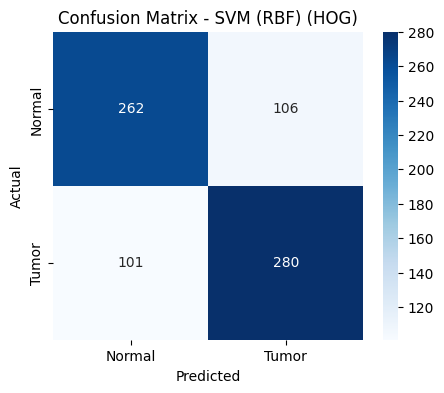


--- Fitur: LBP ---
Akurasi: 0.7250

Classification Report:
              precision    recall  f1-score   support

      Normal       0.70      0.76      0.73       368
       Tumor       0.75      0.69      0.72       381

    accuracy                           0.72       749
   macro avg       0.73      0.73      0.72       749
weighted avg       0.73      0.72      0.72       749



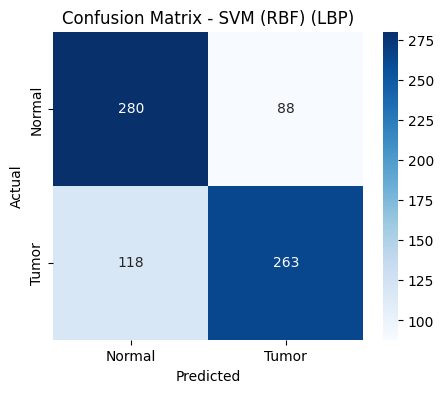


--- Fitur: Histogram Warna ---
Akurasi: 0.7049

Classification Report:
              precision    recall  f1-score   support

      Normal       0.68      0.76      0.72       368
       Tumor       0.74      0.65      0.69       381

    accuracy                           0.70       749
   macro avg       0.71      0.71      0.70       749
weighted avg       0.71      0.70      0.70       749



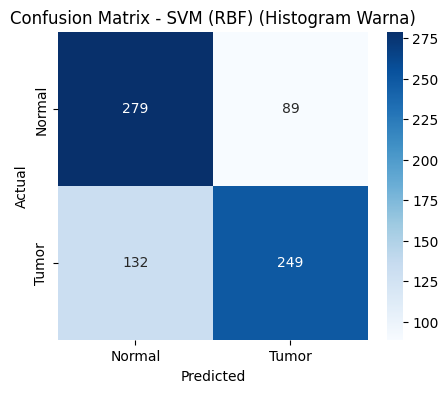


--- Fitur: GLCM ---
Akurasi: 0.6849

Classification Report:
              precision    recall  f1-score   support

      Normal       0.64      0.80      0.71       368
       Tumor       0.75      0.57      0.65       381

    accuracy                           0.68       749
   macro avg       0.70      0.69      0.68       749
weighted avg       0.70      0.68      0.68       749



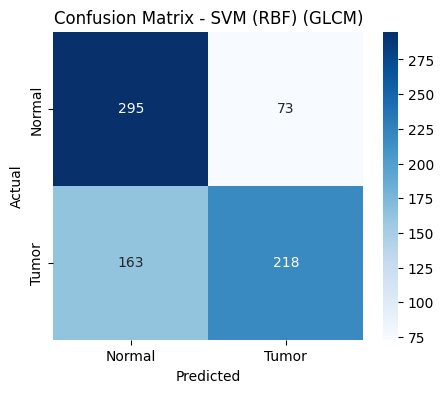


--- Fitur: Hu Moments ---
Akurasi: 0.6302

Classification Report:
              precision    recall  f1-score   support

      Normal       0.60      0.74      0.66       368
       Tumor       0.68      0.52      0.59       381

    accuracy                           0.63       749
   macro avg       0.64      0.63      0.63       749
weighted avg       0.64      0.63      0.63       749



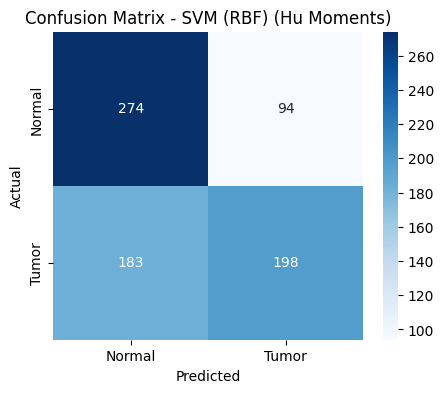


--- Fitur: Edge Histogram ---
Akurasi: 0.6155

Classification Report:
              precision    recall  f1-score   support

      Normal       0.58      0.81      0.67       368
       Tumor       0.70      0.43      0.53       381

    accuracy                           0.62       749
   macro avg       0.64      0.62      0.60       749
weighted avg       0.64      0.62      0.60       749



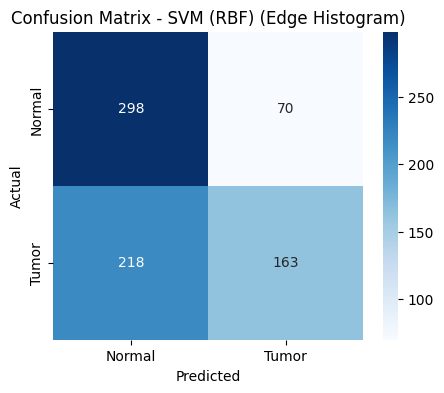


--- Fitur: Gabor Filter ---
Akurasi: 0.6782

Classification Report:
              precision    recall  f1-score   support

      Normal       0.63      0.83      0.72       368
       Tumor       0.76      0.54      0.63       381

    accuracy                           0.68       749
   macro avg       0.70      0.68      0.67       749
weighted avg       0.70      0.68      0.67       749



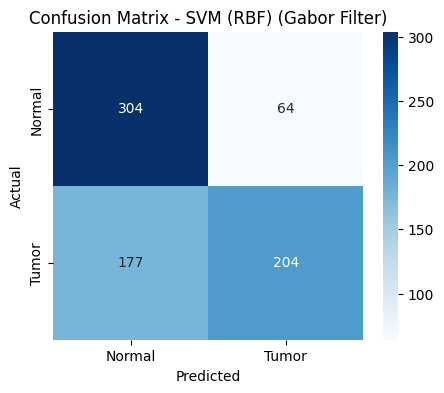


Evaluasi Model: Random Forest

--- Fitur: HOG ---
Akurasi: 0.6956

Classification Report:
              precision    recall  f1-score   support

      Normal       0.70      0.66      0.68       368
       Tumor       0.69      0.73      0.71       381

    accuracy                           0.70       749
   macro avg       0.70      0.70      0.70       749
weighted avg       0.70      0.70      0.70       749



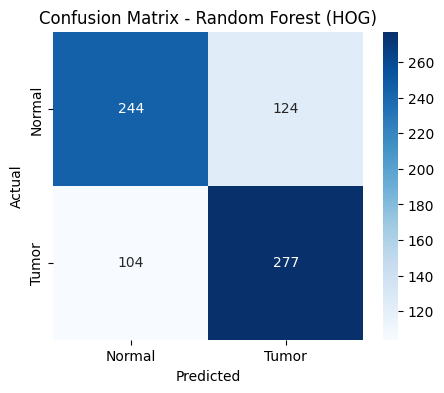


--- Fitur: LBP ---
Akurasi: 0.7036

Classification Report:
              precision    recall  f1-score   support

      Normal       0.68      0.74      0.71       368
       Tumor       0.73      0.67      0.70       381

    accuracy                           0.70       749
   macro avg       0.70      0.70      0.70       749
weighted avg       0.71      0.70      0.70       749



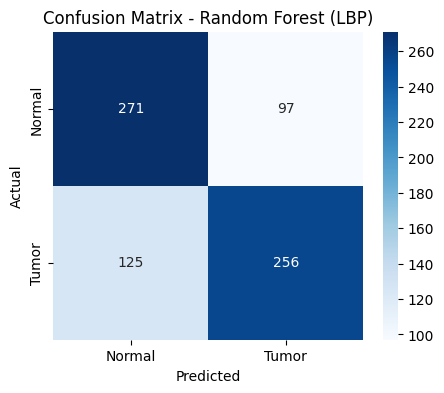


--- Fitur: Histogram Warna ---
Akurasi: 0.7437

Classification Report:
              precision    recall  f1-score   support

      Normal       0.73      0.76      0.74       368
       Tumor       0.76      0.73      0.74       381

    accuracy                           0.74       749
   macro avg       0.74      0.74      0.74       749
weighted avg       0.74      0.74      0.74       749



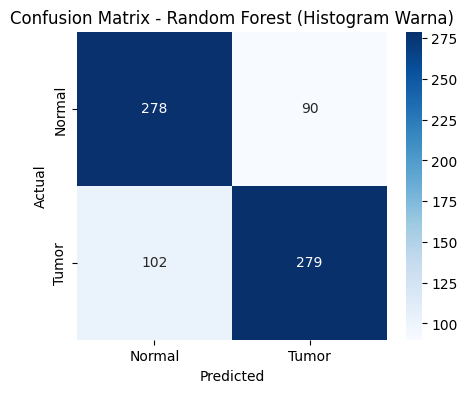


--- Fitur: GLCM ---
Akurasi: 0.6809

Classification Report:
              precision    recall  f1-score   support

      Normal       0.65      0.76      0.70       368
       Tumor       0.72      0.61      0.66       381

    accuracy                           0.68       749
   macro avg       0.69      0.68      0.68       749
weighted avg       0.69      0.68      0.68       749



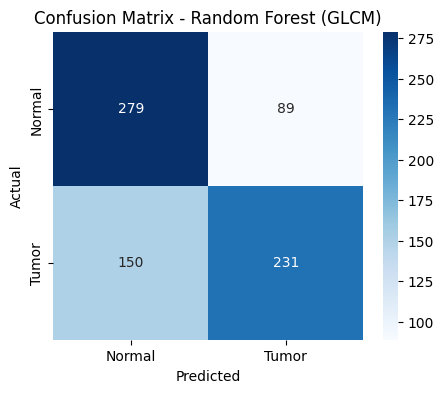


--- Fitur: Hu Moments ---
Akurasi: 0.6128

Classification Report:
              precision    recall  f1-score   support

      Normal       0.60      0.65      0.62       368
       Tumor       0.63      0.57      0.60       381

    accuracy                           0.61       749
   macro avg       0.61      0.61      0.61       749
weighted avg       0.61      0.61      0.61       749



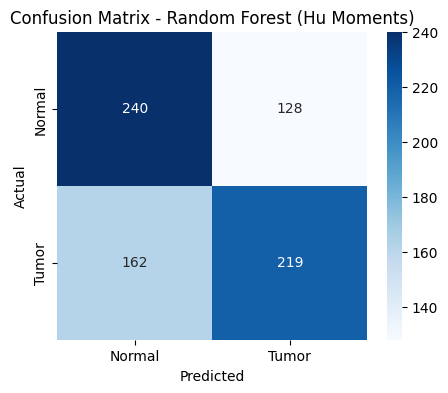


--- Fitur: Edge Histogram ---
Akurasi: 0.5367

Classification Report:
              precision    recall  f1-score   support

      Normal       0.53      0.55      0.54       368
       Tumor       0.55      0.53      0.54       381

    accuracy                           0.54       749
   macro avg       0.54      0.54      0.54       749
weighted avg       0.54      0.54      0.54       749



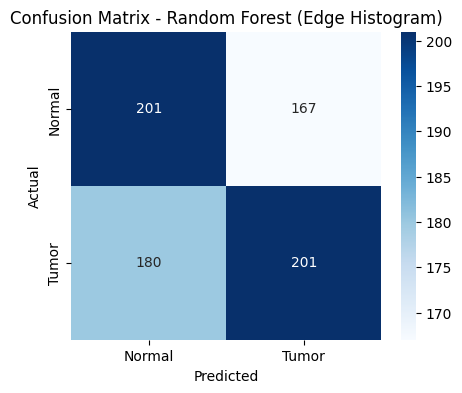


--- Fitur: Gabor Filter ---
Akurasi: 0.6502

Classification Report:
              precision    recall  f1-score   support

      Normal       0.63      0.68      0.66       368
       Tumor       0.67      0.62      0.64       381

    accuracy                           0.65       749
   macro avg       0.65      0.65      0.65       749
weighted avg       0.65      0.65      0.65       749



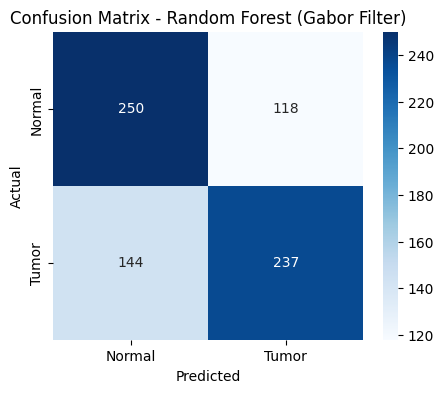


Evaluasi Model: KNN (k=5)

--- Fitur: HOG ---
Akurasi: 0.6742

Classification Report:
              precision    recall  f1-score   support

      Normal       0.68      0.65      0.66       368
       Tumor       0.67      0.70      0.69       381

    accuracy                           0.67       749
   macro avg       0.67      0.67      0.67       749
weighted avg       0.67      0.67      0.67       749



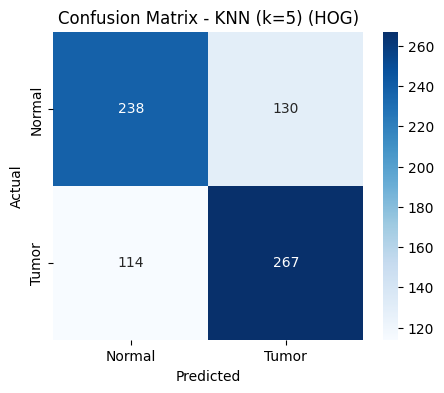


--- Fitur: LBP ---
Akurasi: 0.6729

Classification Report:
              precision    recall  f1-score   support

      Normal       0.65      0.74      0.69       368
       Tumor       0.71      0.61      0.66       381

    accuracy                           0.67       749
   macro avg       0.68      0.67      0.67       749
weighted avg       0.68      0.67      0.67       749



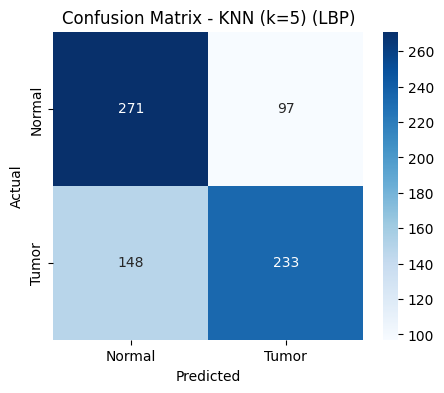


--- Fitur: Histogram Warna ---
Akurasi: 0.6636

Classification Report:
              precision    recall  f1-score   support

      Normal       0.64      0.72      0.68       368
       Tumor       0.69      0.61      0.65       381

    accuracy                           0.66       749
   macro avg       0.67      0.66      0.66       749
weighted avg       0.67      0.66      0.66       749



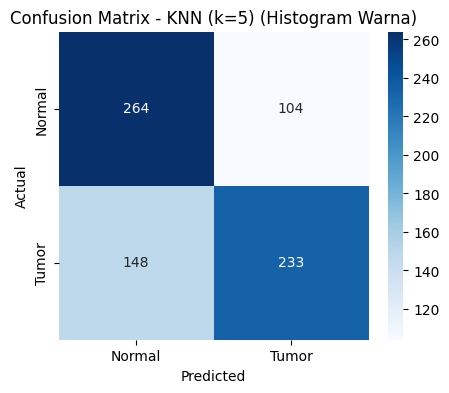


--- Fitur: GLCM ---
Akurasi: 0.6555

Classification Report:
              precision    recall  f1-score   support

      Normal       0.63      0.72      0.67       368
       Tumor       0.69      0.59      0.64       381

    accuracy                           0.66       749
   macro avg       0.66      0.66      0.65       749
weighted avg       0.66      0.66      0.65       749



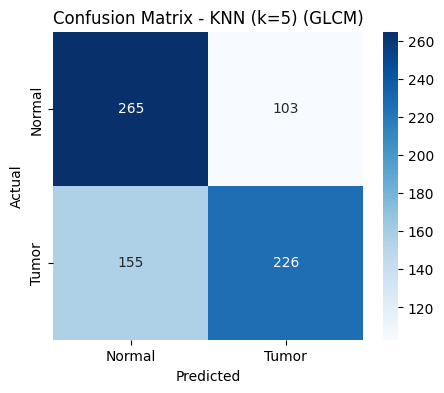


--- Fitur: Hu Moments ---
Akurasi: 0.5888

Classification Report:
              precision    recall  f1-score   support

      Normal       0.57      0.64      0.61       368
       Tumor       0.61      0.54      0.57       381

    accuracy                           0.59       749
   macro avg       0.59      0.59      0.59       749
weighted avg       0.59      0.59      0.59       749



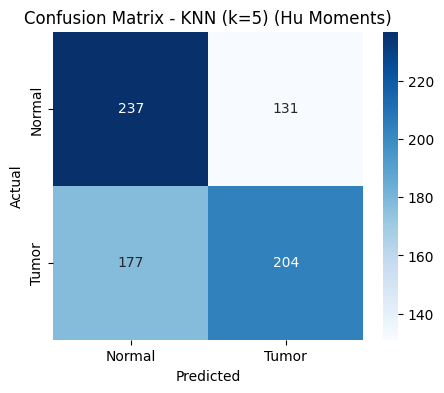


--- Fitur: Edge Histogram ---
Akurasi: 0.5621

Classification Report:
              precision    recall  f1-score   support

      Normal       0.55      0.59      0.57       368
       Tumor       0.57      0.54      0.56       381

    accuracy                           0.56       749
   macro avg       0.56      0.56      0.56       749
weighted avg       0.56      0.56      0.56       749



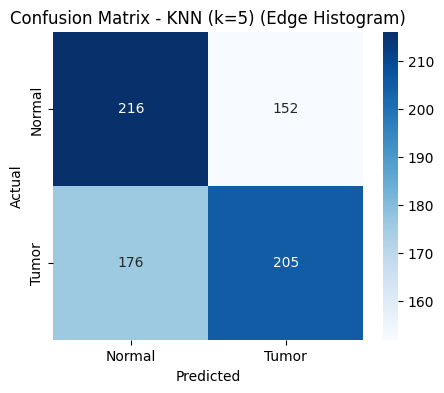


--- Fitur: Gabor Filter ---
Akurasi: 0.6409

Classification Report:
              precision    recall  f1-score   support

      Normal       0.64      0.62      0.63       368
       Tumor       0.64      0.66      0.65       381

    accuracy                           0.64       749
   macro avg       0.64      0.64      0.64       749
weighted avg       0.64      0.64      0.64       749



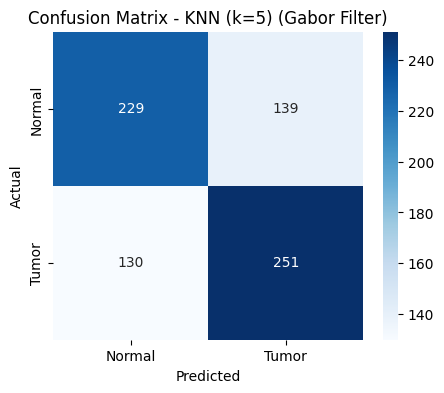

In [ ]:
# ==============================
# 7. Training & Evaluasi per fitur
# ==============================
results = {}

for model_name, model in models.items():
    print(f"\n====================\nEvaluasi Model: {model_name}\n====================")
    results[model_name] = {}
    for feat_name in X_train_feats.keys():
        print(f"\n--- Fitur: {feat_name} ---")
        X_tr = X_train_feats[feat_name]
        X_val = X_val_feats[feat_name]

        # Training
        model.fit(X_tr, y_train_np)
        y_pred = model.predict(X_val)

        # Evaluasi
        acc = accuracy_score(y_val_np, y_pred)
        results[model_name][feat_name] = acc
        print(f"Akurasi: {acc:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_val_np, y_pred, target_names=class_names))
        cm = confusion_matrix(y_val_np, y_pred)
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title(f"Confusion Matrix - {model_name} ({feat_name})")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

In [ ]:
# ==============================
# 8. Ringkasan semua akurasi & model terbaik
# ==============================
print("\n=== Ringkasan Akurasi Semua Model × Fitur ===")
best_acc = 0
best_model = ""
best_feat = ""
for m, feat_dict in results.items():
    for f, acc in feat_dict.items():
        print(f"{m:<15} | {f:<15} | Akurasi: {acc:.4f}")
        if acc > best_acc:
            best_acc = acc
            best_model = m
            best_feat = f

print(f"\n Model terbaik: {best_model} dengan fitur {best_feat} (Akurasi: {best_acc:.4f})")


=== Ringkasan Akurasi Semua Model × Fitur ===
SVM (RBF)       | HOG             | Akurasi: 0.7236
SVM (RBF)       | LBP             | Akurasi: 0.7250
SVM (RBF)       | Histogram Warna | Akurasi: 0.7049
SVM (RBF)       | GLCM            | Akurasi: 0.6849
SVM (RBF)       | Hu Moments      | Akurasi: 0.6302
SVM (RBF)       | Edge Histogram  | Akurasi: 0.6155
SVM (RBF)       | Gabor Filter    | Akurasi: 0.6782
Random Forest   | HOG             | Akurasi: 0.6956
Random Forest   | LBP             | Akurasi: 0.7036
Random Forest   | Histogram Warna | Akurasi: 0.7437
Random Forest   | GLCM            | Akurasi: 0.6809
Random Forest   | Hu Moments      | Akurasi: 0.6128
Random Forest   | Edge Histogram  | Akurasi: 0.5367
Random Forest   | Gabor Filter    | Akurasi: 0.6502
KNN (k=5)       | HOG             | Akurasi: 0.6742
KNN (k=5)       | LBP             | Akurasi: 0.6729
KNN (k=5)       | Histogram Warna | Akurasi: 0.6636
KNN (k=5)       | GLCM            | Akurasi: 0.6555
KNN (k=5)       |

# PENDEKATAN DEEP LEARNING

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

num_classes = len(class_names)

cnn_model = models.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),

    # Block 1
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    # Block 2
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    # Block 3
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,784,130 (98.36 MB)

 Trainable params: 25,784,130 (98.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 20  # bisa ditingkatkan
history = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20


94/94 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.5797 - loss: 55.6944 - val_accuracy: 0.7103 - val_loss: 0.6025
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.7342 - loss: 0.5525 - val_accuracy: 0.6903 - val_loss: 0.6225
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.8239 - loss: 0.3971 - val_accuracy: 0.7116 - val_loss: 0.6458
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.8890 - loss: 0.2732 - val_accuracy: 0.6689 - val_loss: 0.7764
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.9315 - loss: 0.1876 - val_accuracy: 0.6889 - val_loss: 0.9646
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.9582 - loss: 0.1141 - val_accuracy: 0.6716 - val_loss: 1.1988
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.9635 - loss: 0.1113 - val_accuracy: 0.6796 - val_loss: 1.2146
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.9772 - loss: 0.0707 - val_accuracy: 0.6569 - val_loss: 1

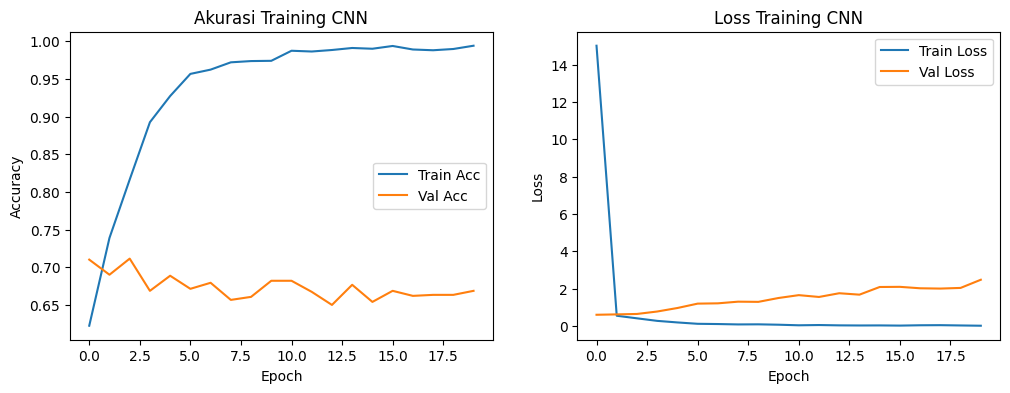

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Akurasi Training CNN")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Training CNN")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step - accuracy: 0.6702 - loss: 2.3172
Akurasi CNN pada validation set: 0.6689
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step


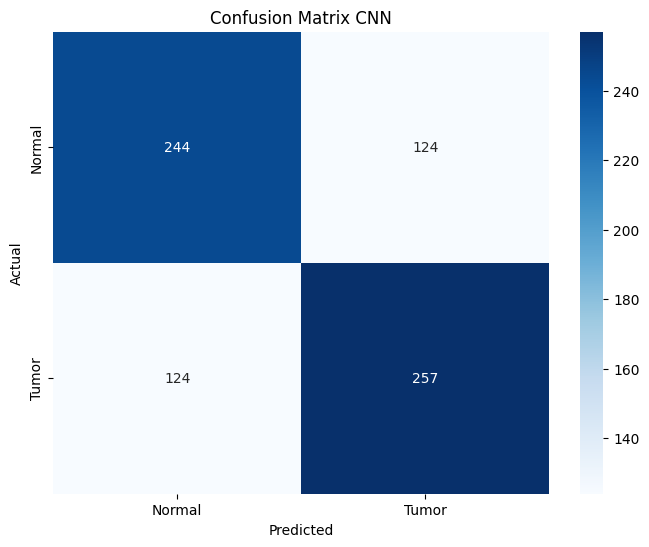

In [ ]:
val_loss, val_acc = cnn_model.evaluate(val_ds)
print(f"Akurasi CNN pada validation set: {val_acc:.4f}")

# Confusion Matrix
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_pred_probs = cnn_model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix CNN")
plt.show()


PRETRAINED model (MobileNetV2)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Tentukan input shape
input_shape = (img_height, img_width, 3)
num_classes = len(class_names)

# Load MobileNetV2 pretrained di ImageNet, tanpa classifier
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False  # freeze semua layer awal

# Tambahkan classifier baru di atas
inputs = layers.Input(shape=input_shape)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

pretrained_model = models.Model(inputs, outputs)

pretrained_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

pretrained_model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
epochs = 10  # awal, bisa ditingkatkan
history_pretrained = pretrained_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 62s 539ms/step - accuracy: 0.5583 - loss: 0.9179 - val_accuracy: 0.6969 - val_loss: 0.5898
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 48s 509ms/step - accuracy: 0.6233 - loss: 0.6959 - val_accuracy: 0.6822 - val_loss: 0.6244
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 49s 524ms/step - accuracy: 0.6806 - loss: 0.6352 - val_accuracy: 0.6943 - val_loss: 0.5887
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 48s 510ms/step - accuracy: 0.6800 - loss: 0.6358 - val_accuracy: 0.7356 - val_loss: 0.5490
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 48s 509ms/step - accuracy: 0.7063 - loss: 0.5762 - val_accuracy: 0.7049 - val_loss: 0.5548
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 50s 528ms/step - accuracy: 0.7103 - loss: 0.5739 - val_accuracy: 0.7316 - val_loss: 0.5438
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 47s 504ms/step - accuracy: 0.7287 - loss: 0.5627 - val_accuracy: 0.7343 - val_loss: 0.5382
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 48s 509ms/step - accuracy: 0.7064 - loss: 0.5931 - val_accu

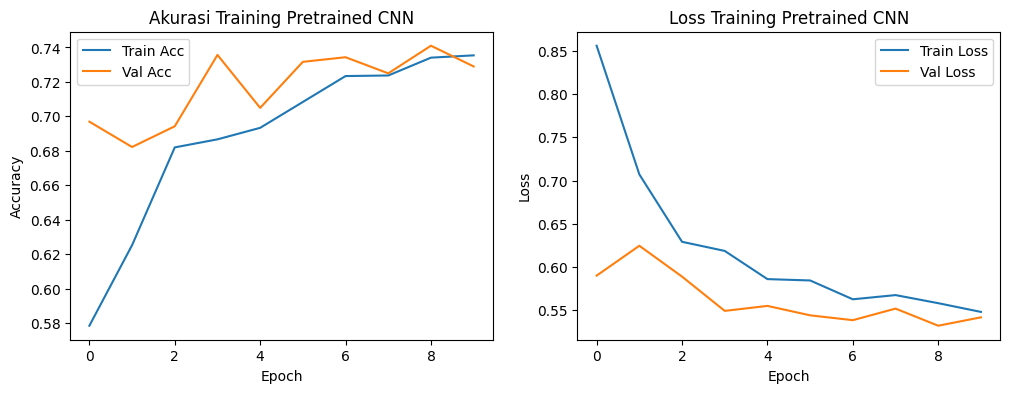

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_pretrained.history['accuracy'], label='Train Acc')
plt.plot(history_pretrained.history['val_accuracy'], label='Val Acc')
plt.title("Akurasi Training Pretrained CNN")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_pretrained.history['loss'], label='Train Loss')
plt.plot(history_pretrained.history['val_loss'], label='Val Loss')
plt.title("Loss Training Pretrained CNN")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 364ms/step - accuracy: 0.7485 - loss: 0.5201
Akurasi Pretrained CNN pada validation set: 0.7290
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 514ms/step


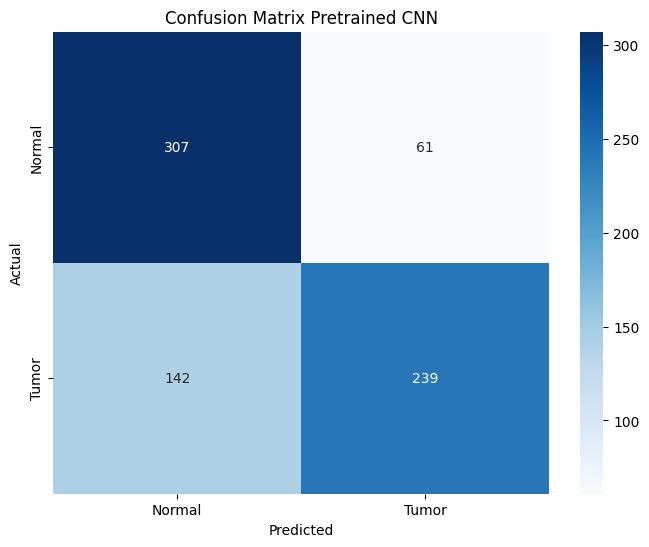

In [ ]:
val_loss, val_acc = pretrained_model.evaluate(val_ds)
print(f"Akurasi Pretrained CNN pada validation set: {val_acc:.4f}")

# Confusion Matrix
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_pred_probs = pretrained_model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Pretrained CNN")
plt.show()


Fine-tunning biasa

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

num_classes = len(class_names)
input_shape = (img_height, img_width, 3)

# Load pretrained base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = True  # semua layer bisa di-train

# Tambahkan classifier baru
inputs = layers.Input(shape=input_shape)
x = preprocess_input(inputs)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

ft_model = models.Model(inputs, outputs)
ft_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

ft_model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,226,434 (8.49 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
epochs = 10
history_ft = ft_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.5995 - loss: 0.7798 - val_accuracy: 0.5274 - val_loss: 1.3224
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.8524 - loss: 0.3498 - val_accuracy: 0.5260 - val_loss: 1.5449
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - accuracy: 0.9388 - loss: 0.1636 - val_accuracy: 0.5981 - val_loss: 1.1114
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step - accuracy: 0.9877 - loss: 0.0567 - val_accuracy: 0.6035 - val_loss: 1.2294
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - accuracy: 0.9992 - loss: 0.0214 - val_accuracy: 0.5928 - val_loss: 1.3996
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 214s 2s/step - accuracy: 0.9983 - loss: 0.0115 - val_accuracy: 0.6302 - val_loss: 1.2932
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 214s 2s/step - accuracy: 1.0000 - loss: 0.0053 - val_accuracy: 0.6355 - val_loss: 1.3603
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 216s 2s/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.6489 - v

Fine Tunning LoRA

In [ ]:
from tensorflow.keras.layers import Layer
import tensorflow as tf

class LoRA(Layer):
    def __init__(self, layer, rank=4, alpha=1.0, **kwargs):
        super().__init__(**kwargs)
        self.layer = layer
        self.rank = rank
        self.alpha = alpha

    def build(self, input_shape):
        self.lora_A = self.add_weight(shape=(input_shape[-1], self.rank),
                                      initializer='random_normal', trainable=True, name='lora_A')
        self.lora_B = self.add_weight(shape=(self.rank, self.layer.units),
                                      initializer='zeros', trainable=True, name='lora_B')
        super().build(input_shape)

    def call(self, inputs):
        original = self.layer(inputs)
        lora_update = tf.matmul(inputs, self.lora_A)
        lora_update = tf.matmul(lora_update, self.lora_B) * self.alpha
        return original + lora_update


In [ ]:
# Freeze base model
base_model.trainable = False

# Tambahkan LoRA pada classifier terakhir
inputs = layers.Input(shape=input_shape)
x = preprocess_input(inputs)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
dense = layers.Dense(num_classes)  # original dense
outputs = LoRA(dense, rank=8, alpha=1.0)(x)
outputs = layers.Activation('softmax')(outputs)

lora_model = models.Model(inputs, outputs)
lora_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

lora_model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_2 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_2 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lo_ra (LoRA)                    │ (None, 2)              │        12,818 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,802 (8.66 MB)

 Trainable params: 12,818 (50.07 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
epochs = 10
history_lora = lora_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 61s 555ms/step - accuracy: 0.6801 - loss: 0.6047 - val_accuracy: 0.7330 - val_loss: 0.6373
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 49s 517ms/step - accuracy: 0.8119 - loss: 0.4361 - val_accuracy: 0.7477 - val_loss: 0.6391
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 54s 572ms/step - accuracy: 0.8335 - loss: 0.3826 - val_accuracy: 0.7530 - val_loss: 0.6196
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 50s 536ms/step - accuracy: 0.8542 - loss: 0.3378 - val_accuracy: 0.7437 - val_loss: 0.6174
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 48s 517ms/step - accuracy: 0.8584 - loss: 0.3270 - val_accuracy: 0.7543 - val_loss: 0.6171
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 48s 511ms/step - accuracy: 0.8512 - loss: 0.3330 - val_accuracy: 0.7503 - val_loss: 0.6208
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 47s 506ms/step - accuracy: 0.8683 - loss: 0.3007 - val_accuracy: 0.7437 - val_loss: 0.6442
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 48s 517ms/step - accuracy: 0.8586 - loss: 0.3253 - val_accu

24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 428ms/step
Fine-Tuning Biasa Accuracy: 0.6542


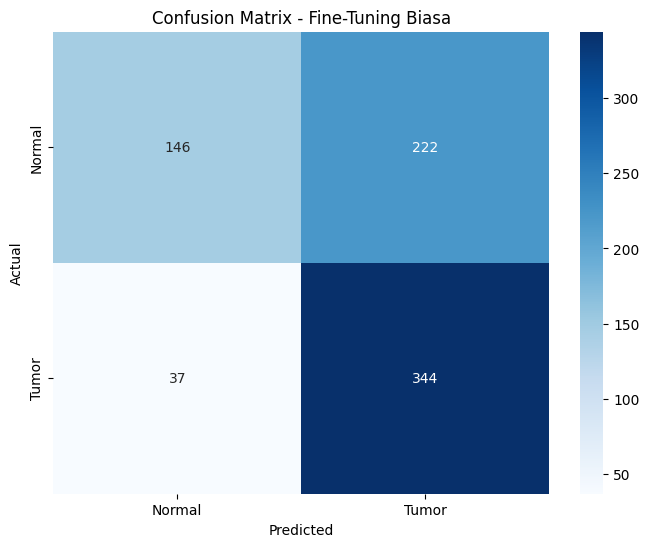

24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 520ms/step
Fine-Tuning LoRA Accuracy: 0.7370


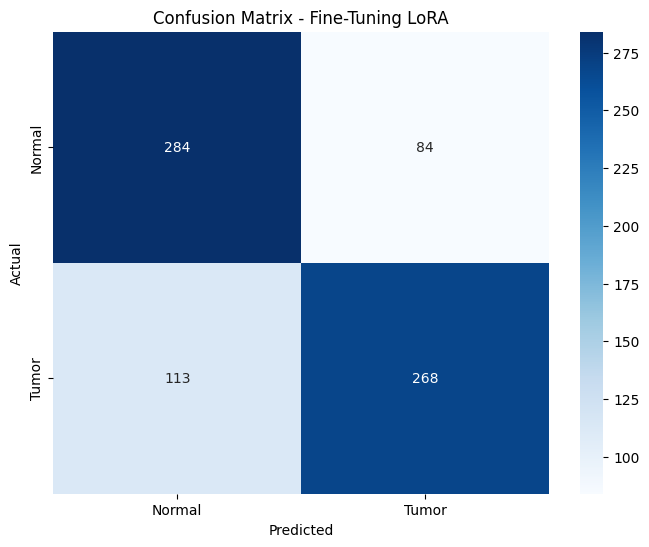

In [ ]:
#Evaluasi perbandingan fine-tunning biasa dan fine-tunning lora
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def eval_model(model, ds, title):
    y_true = np.concatenate([y for x, y in ds], axis=0)
    y_pred_probs = model.predict(ds)
    y_pred = np.argmax(y_pred_probs, axis=1)

    acc = np.mean(y_pred == y_true)
    print(f"{title} Accuracy: {acc:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {title}")
    plt.show()

# Evaluasi
eval_model(ft_model, val_ds, "Fine-Tuning Biasa")
eval_model(lora_model, val_ds, "Fine-Tuning LoRA")


Evaluasi Deep Learning

In [ ]:
dl_models = {
    "CNN dari Awal": cnn_model,
    "Pretrained FT": ft_model,
    "Pretrained LoRA": lora_model
}

# Jika ingin pakai Dense NN dengan fitur terbaik
use_features = True  # True jika ingin pakai fitur HOG+LBP+GLCM+Hu sebagai input
best_features = ["HOG", "LBP", "GLCM", "Hu Moments"]
if use_features:
    X_train_input = np.concatenate([X_train_feats[f] for f in best_features], axis=1)
    X_val_input   = np.concatenate([X_val_feats[f] for f in best_features], axis=1)
else:
    X_train_input = None  # pakai image dataset langsung
    X_val_input   = None


In [ ]:
def evaluate_dl_model(model_name, model, X_train=None, X_val=None, ds_val=None):
    print(f"\n====================\nEvaluasi Model: {model_name}\n====================")

    if X_train is not None and X_val is not None:
        # Dense NN dengan fitur terbaik
        model.fit(X_train, y_train_np, epochs=20, batch_size=32, verbose=0)
        y_pred = np.argmax(model.predict(X_val), axis=1)
        y_true = y_val_np
    else:
        # CNN / Pretrained model dengan image dataset
        y_true = np.concatenate([y for x, y in ds_val], axis=0)
        y_pred_probs = model.predict(ds_val)
        y_pred = np.argmax(y_pred_probs, axis=1)

    # Akurasi
    acc = accuracy_score(y_true, y_pred)
    print(f"Akurasi: {acc:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return acc



Evaluasi Model: CNN dari Awal
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step
Akurasi: 0.6689

Classification Report:
              precision    recall  f1-score   support

      Normal       0.66      0.66      0.66       368
       Tumor       0.67      0.67      0.67       381

    accuracy                           0.67       749
   macro avg       0.67      0.67      0.67       749
weighted avg       0.67      0.67      0.67       749



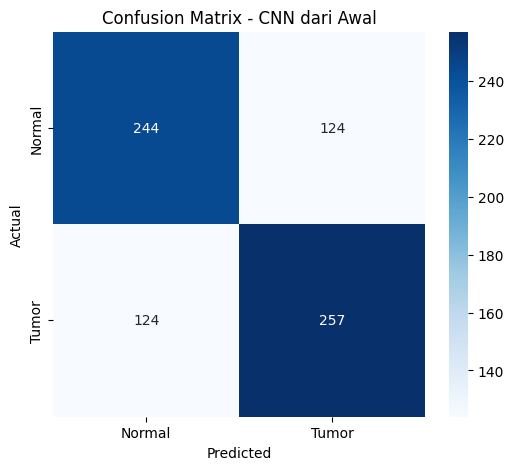


Evaluasi Model: Pretrained FT
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 384ms/step
Akurasi: 0.6542

Classification Report:
              precision    recall  f1-score   support

      Normal       0.80      0.40      0.53       368
       Tumor       0.61      0.90      0.73       381

    accuracy                           0.65       749
   macro avg       0.70      0.65      0.63       749
weighted avg       0.70      0.65      0.63       749



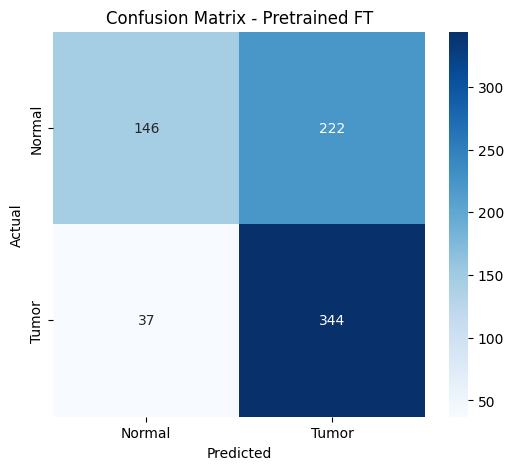


Evaluasi Model: Pretrained LoRA
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 387ms/step
Akurasi: 0.7370

Classification Report:
              precision    recall  f1-score   support

      Normal       0.72      0.77      0.74       368
       Tumor       0.76      0.70      0.73       381

    accuracy                           0.74       749
   macro avg       0.74      0.74      0.74       749
weighted avg       0.74      0.74      0.74       749



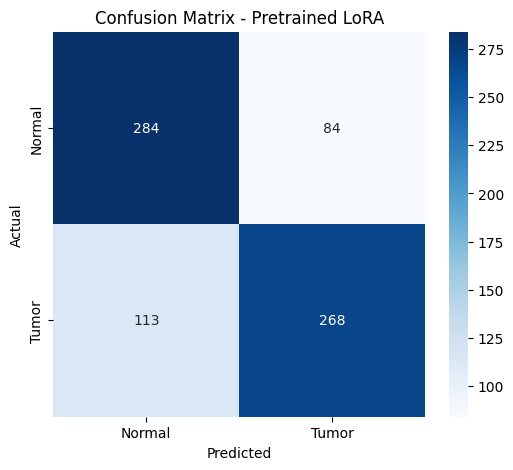


Ringkasan Akurasi Deep Learning:
             Model  Accuracy
0    CNN dari Awal  0.668892
1    Pretrained FT  0.654206
2  Pretrained LoRA  0.736983


In [ ]:
dl_results = {}

for model_name, model in dl_models.items():
    # Jika model Dense NN → pakai fitur numerik
    if use_features and "Dense" in model_name:
        dl_results[model_name] = evaluate_dl_model(
            model_name, model, X_train_input, X_val_input
        )
    else:
        # CNN atau Pretrained → pakai dataset gambar
        dl_results[model_name] = evaluate_dl_model(
            model_name, model, ds_val=val_ds
        )

# Ringkasan
import pandas as pd
summary_df = pd.DataFrame(list(dl_results.items()), columns=["Model", "Accuracy"])
print("\nRingkasan Akurasi Deep Learning:")
print(summary_df)


In [ ]:
pip install vit-keras

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.


   ---------------------------------------- 0/2 [validators]
   ---------------------------------------- 0/2 [validators]
   ---------------------------------------- 0/2 [validators]
   ---------------------------------------- 2/2 [vit-keras]




[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
!pip install transformers

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/12.0 MB ? eta -:--:--
   -- ------------------------------------- 0.8/12.0 MB 4.2 MB/s eta 0:00:03
   ----- ---------------------------------- 1.6/12.0 MB 4.4 MB/s eta 0:00:03
   -------- ------------------------------- 2.6/12.0 MB 4.7 MB/s eta 0:00:02
   ------------- -------------------------- 3.9/12.0 MB 4.8 MB/s eta 0:00:02
   ---------------- ----------------------- 5.0/12.0 MB 4.9 MB/s eta 0:00:02
   -------------------- ------------------- 6.0/12.0 MB 4.9 MB/s eta 0:00:02
   --------------------- ------------------ 6.6/12.0 MB 4.6 MB/s eta 0:00:02
   ------------------------- -------------- 7.6/12.0 MB 4.6 MB/s eta 0:00:01
   ---------------------------- ----------- 8.7/12.0 MB 4.6 MB/s eta 0:00:01
   ------------------------------- -------- 9.4/12.0 MB 4.6 MB/s eta 0:00:01
   ---------------------------------- ----- 10.5/12.0 MB 4.6 MB/s eta 0:00:01
   -


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
!pip install keras-cv-attention-models

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/802.6 kB ? eta -:--:--
   ------------- -------------------------- 262.1/802.6 kB ? eta -:--:--
   ---------------------------------------- 802.6/802.6 kB 3.1 MB/s eta 0:00:00

   ---------------------------------------- 0/2 [ftfy]
   ---------------------------------------- 0/2 [ftfy]
   -------------------- ------------------- 1/2 [keras-cv-attention-models]
   -------------------- ------------------- 1/2 [keras-cv-attention-models]
   -------------------- ------------------- 1/2 [keras-cv-attention-models]
   -------------------- ------------------- 1/2 [keras-cv-attention-models]
   -------------------- ------------------- 1/2 [keras-cv-attention-models]
   -------------------- ------------------- 1/2 [keras-cv-attention-models]
   -------------------- ------------------- 1/2 [keras-cv-attention-models]
   -------------------- ------------------- 1/2 [keras-


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
pip install keras-cv-attention-models

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import keras_cv_attention_models
dir(keras_cv_attention_models)

[WARNING] Currently tensorflow>=2.16 with keras 3 not supported, try pip install tf-keras~=2.16 and set TF_USE_LEGACY_KERAS=1 if error.


['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 'aotnet',
 'attention_layers',
 'backend',
 'beit',
 'botnet',
 'caformer',
 'clip',
 'cmt',
 'coat',
 'coatnet',
 'coco',
 'common_layers',
 'convnext',
 'cotnet',
 'cspnext',
 'davit',
 'dinat',
 'dinov2',
 'download_and_load',
 'edgenext',
 'efficientdet',
 'efficientformer',
 'efficientnet',
 'efficientvit',
 'efficientvit_b',
 'efficientvit_m',
 'eva',
 'eva02',
 'fasternet',
 'fastervit',
 'fastvit',
 'fbnetv3',
 'flexivit',
 'gated_mlp',
 'gcvit',
 'ghostnet',
 'ghostnetv2',
 'gpt2',
 'gpvit',
 'halonet',
 'hiera',
 'hornet',
 'iformer',
 'imagenet',
 'inceptionnext',
 'lcnet',
 'levit',
 'llama2',
 'maxvit',
 'meta_transformer',
 'mlp_family',
 'mlp_mixer',
 'mobilenetv3',
 'mobilenetv3_family',
 'mobilevit',
 'model_surgery',
 'models',
 'moganet',
 'nat',
 'nfnets',
 'plot_func',
 'pvt',
 'regnet',
 'repvit',
 'res_mlp',
 'resnest',
 

In [ ]:
from keras_cv_attention_models import vit
dir(vit)

['Beit',
 'ViT',
 'ViTBasePatch16',
 'ViTLargePatch14',
 'ViTText',
 'ViTTextLargePatch14',
 'ViTTinyPatch16',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'keras_model_load_weights_from_pytorch_model',
 'register_model']

In [ ]:
from keras_cv_attention_models.beit import vit as beit_vit
dir(beit_vit)

['Beit',
 'ViT',
 'ViTBasePatch16',
 'ViTLargePatch14',
 'ViTText',
 'ViTTextLargePatch14',
 'ViTTinyPatch16',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'keras_model_load_weights_from_pytorch_model',
 'register_model']

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

image_size = 224
num_classes = 2

base = tf.keras.applications.ConvNeXtTiny(
    include_top=False,
    weights="imagenet",
    input_shape=(image_size, image_size, 3)
)

base.trainable = False

inputs = layers.Input((image_size, image_size, 3))
x = tf.keras.applications.convnext.preprocess_input(inputs)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs, outputs)
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 28s 0us/step


In [ ]:
pip install timm torch torchvision --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
ls

 Volume in drive C is Windows-SSD
 Volume Serial Number is BECD-62A3

 Directory of c:\Users\Amanda RW\.vscode\machinelaerning

22/11/2025  19:18    <DIR>          .
22/11/2025  19:16    <DIR>          ..
22/11/2025  19:19    <DIR>          Label
23/11/2025  03:16         4.071.044 Project_Machine_Learning.ipynb
               1 File(s)      4.071.044 bytes
               3 Dir(s)  10.125.549.568 bytes free


## TRansform

In [ ]:
# ============================================
# IMPORT
# ============================================
import torch
import timm
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import os

# ============================================
# KONFIGURASI
# ============================================
data_dir = r"C:\Users\Amanda RW\.vscode\machinelaerning\Label"
class_names = sorted(os.listdir(data_dir))

image_size = 224
batch_size = 16        # lebih kecil = lebih cepat di CPU
num_classes = len(class_names)
device = "cuda" if torch.cuda.is_available() else "cpu"

print("Device:", device)
print("Class names:", class_names)

# ============================================
# TRANSFORM
# ============================================
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

# ============================================
# DATASET
# ============================================
class CustomDataset(Dataset):
    def __init__(self, folder):
        self.paths = []
        self.labels = []

        for idx, label_name in enumerate(class_names):
            class_folder = os.path.join(folder, label_name)
            for file in os.listdir(class_folder):
                fpath = os.path.join(class_folder, file)
                if os.path.isfile(fpath):
                    self.paths.append(fpath)
                    self.labels.append(idx)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        label = self.labels[idx]

        img = Image.open(img_path).convert("RGB")
        img = transform(img)
        return img, label

# ============================================
# LOAD FULL DATASET
# ============================================
full_dataset = CustomDataset(data_dir)
total_len = len(full_dataset)

train_len = int(0.8 * total_len)
val_len = total_len - train_len
train_data, val_data = random_split(full_dataset, [train_len, val_len])

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

print("Train images:", train_len)
print("Val images:", val_len)

# ============================================
# MODEL: EfficientNet-B0
# ============================================
model = timm.create_model(
    "efficientnet_b0",
    pretrained=True,
    num_classes=num_classes
).to(device)

# ============================================
# TRAINING SETUP
# ============================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs = 5

# ============================================
# TRAINING LOOP (FAST CPU)
# ============================================
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {total_loss/len(train_loader):.4f}")

# ============================================
# VALIDASI
# ============================================
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (preds == labels).sum().item()

val_acc = correct / total * 100
print(f"Validation Accuracy: {val_acc:.2f}%")


Device: cpu
Class names: ['Normal', 'Tumor']
Train images: 2996
Val images: 750
Epoch 1/5 - Train Loss: 1.4784
Epoch 2/5 - Train Loss: 0.4392
Epoch 3/5 - Train Loss: 0.2601
Epoch 4/5 - Train Loss: 0.1529
Epoch 5/5 - Train Loss: 0.1488
Validation Accuracy: 76.67%


In [ ]:
# ============================================
# IMPORT
# ============================================
import torch
import timm
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import os

# ============================================
# CONFIG (GANTI PATH WINDOWS)
# ============================================
data_dir = r"C:\Users\Amanda RW\.vscode\machinelaerning\Label"
class_names = sorted(os.listdir(data_dir))

image_size = 224
batch_size = 16   # lebih kecil → lebih cepat di CPU
num_classes = len(class_names)
device = "cuda" if torch.cuda.is_available() else "cpu"

print("Device:", device)
print("Classes:", class_names)

# ============================================
# TRANSFORM
# ============================================
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

# ============================================
# DATASET
# ============================================
class CustomDataset(Dataset):
    def __init__(self, folder):
        self.paths, self.labels = [], []
        for idx, label in enumerate(class_names):
            folder_class = os.path.join(folder, label)
            for img_file in os.listdir(folder_class):
                path = os.path.join(folder_class, img_file)
                if os.path.isfile(path):
                    self.paths.append(path)
                    self.labels.append(idx)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        return transform(img), self.labels[idx]

# ============================================
# LOAD DATA
# ============================================
dataset_full = CustomDataset(data_dir)
train_len = int(0.8 * len(dataset_full))
val_len = len(dataset_full) - train_len

train_data, val_data = random_split(dataset_full, [train_len, val_len])

# DataLoader versi cepat untuk Windows
train_loader = DataLoader(
    train_data, batch_size=batch_size, shuffle=True,
    num_workers=0, pin_memory=True
)
val_loader = DataLoader(
    val_data, batch_size=batch_size, shuffle=False,
    num_workers=0, pin_memory=True
)

print("Train:", train_len)
print("Val:", val_len)

# ============================================
# MODEL (FAST MODEL)
# ============================================
model = timm.create_model(
    "efficientnet_b0",    # jauh lebih cepat daripada ViT
    pretrained=True,
    num_classes=num_classes
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ============================================
# TRAINING LOOP
# ============================================
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(train_loader):.4f}")

# ============================================
# VALIDATION
# ============================================
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        preds = model(imgs).argmax(1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

print(f"Validation Accuracy: {correct/total*100:.2f}%")


Device: cpu
Classes: ['Normal', 'Tumor']
Train: 2996
Val: 750
Epoch 1/5 - Loss: 1.4179
Epoch 2/5 - Loss: 0.4644
Epoch 3/5 - Loss: 0.2164
Epoch 4/5 - Loss: 0.1504
Epoch 5/5 - Loss: 0.1198
Validation Accuracy: 76.53%


In [ ]:
# ============================================
# MODEL: EfficientNet-B0 + FAST LINEAR PROBING
# ============================================
model = timm.create_model(
    "efficientnet_b0",
    pretrained=True,
    num_classes=num_classes
).to(device)

# Freeze semua backbone
for name, param in model.named_parameters():
    if "classifier" not in name:
        param.requires_grad = False

# Hanya classifier yang dilatih
for p in model.classifier.parameters():
    p.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3
)

scaler = torch.cuda.amp.GradScaler()

# ============================================
# TRAINING
# ============================================
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(imgs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    print(f"[EffB0] Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(train_loader):.4f}")

# ============================================
# VALIDATION
# ============================================
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        pred = model(imgs).argmax(1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)

print(f"[EffB0] Validation Accuracy: {correct/total*100:.2f}%")


C:\Users\Amanda RW\AppData\Local\Temp\ipykernel_13720\1551083553.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
C:\Users\Amanda RW\AppData\Local\Temp\ipykernel_13720\1551083553.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\Amanda RW\AppData\Roaming\Python\Python312\site-packages\torch\amp\autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


[EffB0] Epoch 1/5 - Loss: 2.1079
[EffB0] Epoch 2/5 - Loss: 1.6654
[EffB0] Epoch 3/5 - Loss: 1.4225
[EffB0] Epoch 4/5 - Loss: 1.3461
[EffB0] Epoch 5/5 - Loss: 1.2255
[EffB0] Validation Accuracy: 60.93%


<Figure size 600x600 with 0 Axes>

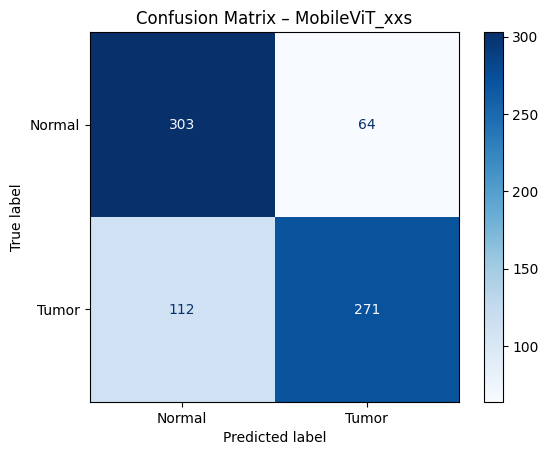

Classification Report:

              precision    recall  f1-score   support

      Normal     0.7301    0.8256    0.7749       367
       Tumor     0.8090    0.7076    0.7549       383

    accuracy                         0.7653       750
   macro avg     0.7695    0.7666    0.7649       750
weighted avg     0.7704    0.7653    0.7647       750



In [ ]:
# ============================================
# EVALUASI: CONFUSION MATRIX + METRICS
# ============================================
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Simpan semua prediksi & label
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ===============================
# Confusion Matrix
# ===============================
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – MobileViT_xxs")
plt.show()

# ===============================
# Precision, Recall, F1-score
# ===============================
report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
print("Classification Report:\n")
print(report)


In [ ]:
# ============================================
# IMPORT
# ============================================
import torch
import timm
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# ============================================
# KONFIGURASI
# ============================================
data_dir = r"C:\Users\Amanda RW\.vscode\machinelaerning\Label"
class_names = sorted(os.listdir(data_dir))

image_size = 224
batch_size = 16
num_classes = len(class_names)
device = "cuda" if torch.cuda.is_available() else "cpu"

print("Device:", device)
print("Classes:", class_names)


# ============================================
# TRANSFORM
# ============================================
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])


# ============================================
# CUSTOM DATASET
# ============================================
class CustomDataset(Dataset):
    def __init__(self, folder):
        self.paths, self.labels = [], []

        for idx, label in enumerate(class_names):
            folder_class = os.path.join(folder, label)
            for f in os.listdir(folder_class):
                path = os.path.join(folder_class, f)
                if os.path.isfile(path):
                    self.paths.append(path)
                    self.labels.append(idx)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = transform(img)
        return img, self.labels[idx]


# ============================================
# LOAD DATA
# ============================================
dataset_full = CustomDataset(data_dir)
train_len = int(0.8 * len(dataset_full))
val_len = len(dataset_full) - train_len

train_data, val_data = random_split(dataset_full, [train_len, val_len])

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=0)

print("Train samples:", train_len)
print("Val samples:", val_len)



Device: cpu
Classes: ['Normal', 'Tumor']
Train samples: 2996
Val samples: 750


In [ ]:
# ============================================
# MODEL: MobileViT (LINEAR PROBING)
# ============================================
model = timm.create_model(
    "mobilevit_xxs",
    pretrained=True,
    num_classes=num_classes
).to(device)

# Freeze seluruh backbone
for name, param in model.named_parameters():
    if "head" not in name and "classifier" not in name:
        param.requires_grad = False

# Pastikan classifier aktif dilatih
for p in model.get_classifier().parameters():
    p.requires_grad = True

print("Trainable parameters:")
print(sum(p.numel() for p in model.parameters() if p.requires_grad))


# ============================================
# TRAINING SETUP
# ============================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3
)

epochs = 7


# ============================================
# TRAINING LOOP
# ============================================
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"[Epoch {epoch+1}/{epochs}] Train Loss: {total_loss/len(train_loader):.4f}")


# ============================================
# VALIDATION
# ============================================
model.eval()
correct = 0
total = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = model(imgs)
        preds = outputs.argmax(1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

val_acc = correct / total * 100
print(f"\nValidation Accuracy: {val_acc:.2f}%")



Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/5.14M [00:00<?, ?B/s]

Trainable parameters:
642
[Epoch 1/7] Train Loss: 0.6346
[Epoch 2/7] Train Loss: 0.5858
[Epoch 3/7] Train Loss: 0.5642
[Epoch 4/7] Train Loss: 0.5486
[Epoch 5/7] Train Loss: 0.5447
[Epoch 6/7] Train Loss: 0.5439
[Epoch 7/7] Train Loss: 0.5379

Validation Accuracy: 73.47%


<Figure size 600x600 with 0 Axes>

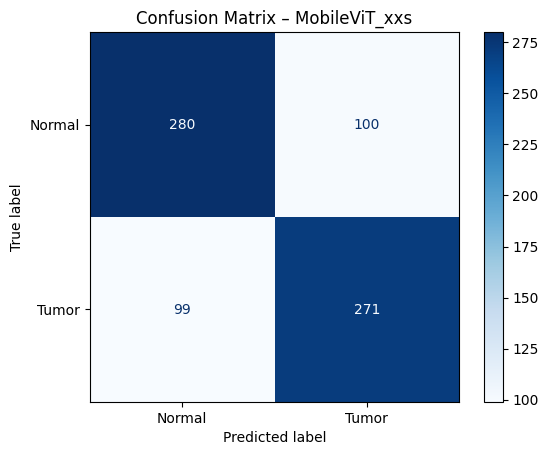

Classification Report:

              precision    recall  f1-score   support

      Normal     0.7388    0.7368    0.7378       380
       Tumor     0.7305    0.7324    0.7314       370

    accuracy                         0.7347       750
   macro avg     0.7346    0.7346    0.7346       750
weighted avg     0.7347    0.7347    0.7347       750



In [ ]:
# ============================================
# EVALUASI: CONFUSION MATRIX + METRICS
# ============================================
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Simpan semua prediksi & label
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ===============================
# Confusion Matrix
# ===============================
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – MobileViT_xxs")
plt.show()

# ===============================
# Precision, Recall, F1-score
# ===============================
report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
print("Classification Report:\n")
print(report)


In [ ]:
import torch

# pastikan 'model' adalah model yang sudah selesai di-training
torch.save(model, "model_best.pth")

print("✅ model_best.pth berhasil disimpan")